# Домашнее задание «Элементарные методы анализа временных рядов»

***Цель:***
    Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Для данной задачи возьмем ряд airlines - "Количество пассажиров международных авиакомпаний, тыс":

In [4]:
airlines = pd.read_csv("Series/international-airline-passengers.csv")
airlines.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Count   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Познакомимся с файлом:

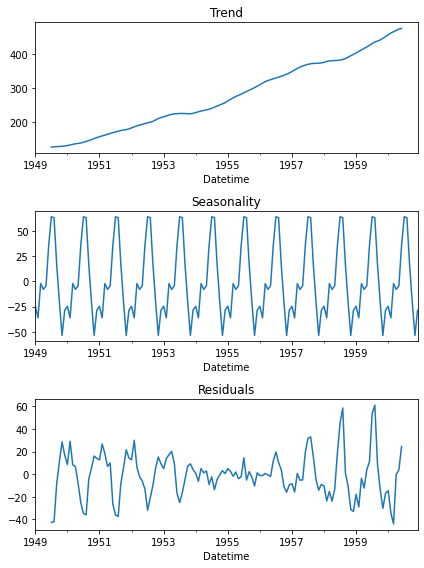

In [6]:
# подготовка к работе:
airlines['Datetime'] = pd.to_datetime(airlines['Month'])
airlines = airlines.set_index('Datetime')
airlines = airlines.drop('Month', axis=1)

# Теперь разложим ряд на тренд,  сезонную компоненту и остаток.

decomposed = seasonal_decompose(airlines)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

Итак, можно сказать, что у ряда есть и тренд, и сезонность, а остатки хаотичны.

Теперь воспроизведем функции для графика Дики-Фуллера и графиков коррелограмм:

In [7]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


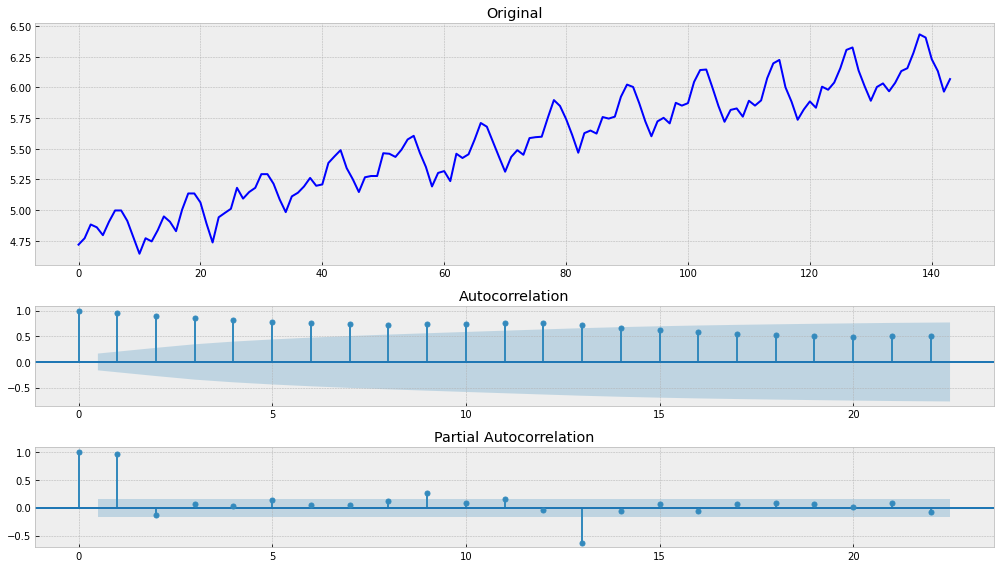

In [8]:
tsplot(boxcox(airlines['Count'], 0))

Для бОльшей стационарности ряда уберем тренд и сезонность:

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


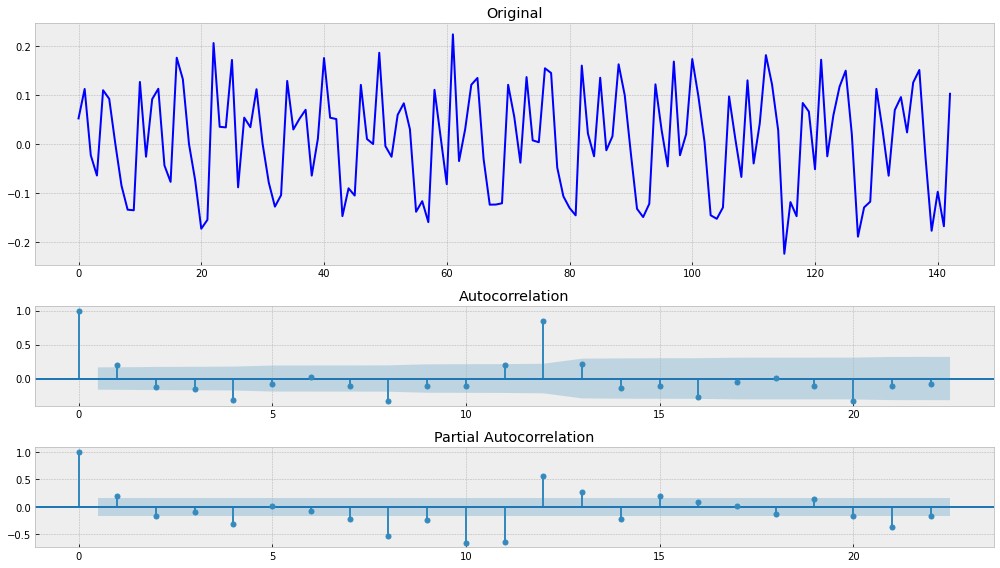

In [9]:
a_trend = boxcox(airlines['Count'], 0)[1:] - boxcox(airlines['Count'], 0)[:-1]
tsplot(a_trend)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


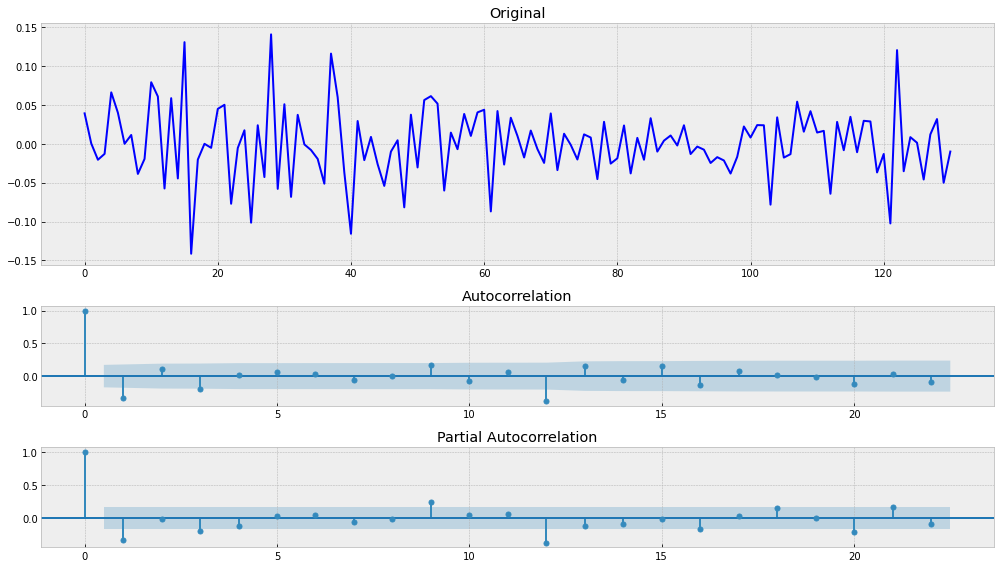

In [10]:
a = a_trend[12:] - a_trend[:-12]
tsplot(a)

Отлично. Теперь ряд стал более стационарным (в нем нет ни тренда, ни сезонности). Переходим непосредственно к заданию:   
1. Берем изначальный ряд (у него есть и тренд, и сезонность):

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


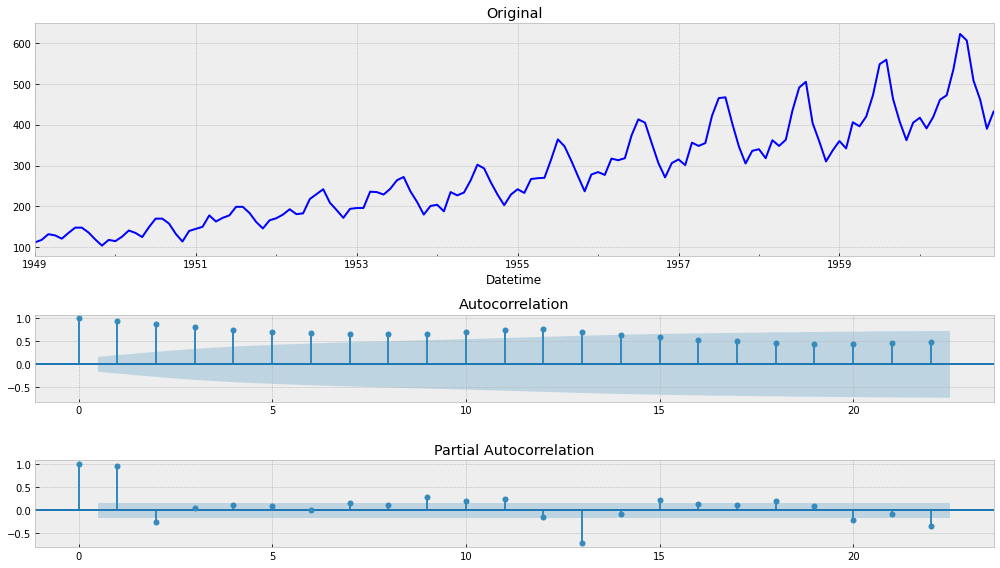

In [11]:
tsplot(airlines['Count'])

Мы убедились, что действительно и сезонность, и тренд явно видны на графике Дики-Фуллера и графиках коррелограмм.  
Поэтому для сглаживания этой версии ряда используем тройное экспоненциальное сглаживание, а именно - Метод Хольта-Винтерса (TEMA), потому что его метод учитывает не только **тренд**, но и **сезонность**. Согласно этому методу, в уровне из значения ряда вычитается сезонная компонента, в то время как тренд остаётся без изменений:

In [12]:
airlines['TES'] = ExponentialSmoothing(airlines['Count'],trend='add',seasonal='mul',seasonal_periods=12).fit().fittedvalues

In [13]:
airlines.head()

,Count,TES
Datetime,,
1949-01-01,112,111.418547
1949-02-01,118,120.062811
1949-03-01,132,134.826830
1949-04-01,129,130.594122
1949-05-01,121,124.086464


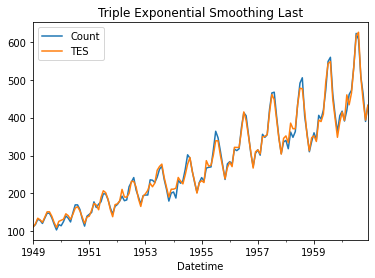

In [14]:
airlines.plot(title='Triple Exponential Smoothing Last').autoscale(axis='x',tight=True)

Переходим к варианту 2.  
2. Стационарный ряд - "a". Наш ряд не имеет четкого тренда и сезонности (об этом мы позаботились), соответственно для него мы можем применить экспоненциальное сглаживание:

In [15]:
alpha = 0.8

In [16]:
a1 = SimpleExpSmoothing(pd.Series(a)).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

In [17]:
a_new = pd.DataFrame()
a_new['count_stationary'] = a
a_new['count_single_exp'] = a1
a_new.head()

,count_stationary,count_single_exp
0,0.039164,0.039164
1,0.000361,0.008121
2,-0.020496,-0.014772
3,-0.012939,-0.013306
4,0.066148,0.050258


<AxesSubplot:title={'center':'Single Exponential Smoothing'}>

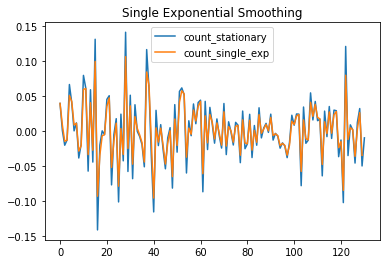

In [18]:
a_new.plot(title='Single Exponential Smoothing')

Теперь посмотрим, какая модель лучше всего приближает исходные данные. 
Будем минимизировать стандарнтый RMSE:

1. Первоначальный ряд "airlines"

In [19]:
series = airlines["Count"]

In [20]:
train, test, val = series[:60], series[60:70], series[70:]

In [21]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fcast1 = fit1.forecast(len(test))

In [22]:
mse1_test = ((fcast1 - test) ** 2).mean()
print('The Root Mean Squared Error of additive trend for \033[1m test \033[0;0m period, multiplicative seasonal of '+ 
      'period season_length={} and a Box-Cox transformation {}'.format(12,round(np.sqrt(mse1_test), 2)))

The Root Mean Squared Error of additive trend for  test  period, multiplicative seasonal of period season_length=12 and a Box-Cox transformation 13.69


In [23]:
fit1_1 = ExponentialSmoothing(train.append(test), seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fcast1_1 = fit1_1.forecast(len(val))

In [24]:
mse1_valid = ((fcast1_1 - val) ** 2).mean()
print('The Root Mean Squared Error of additive trend for \033[1m val \033[0;0m period, multiplicative seasonal of '+ 
      'period season_length={} and a Box-Cox transformation {}'.format(12,round(np.sqrt(mse1_valid), 2)))

The Root Mean Squared Error of additive trend for  val  period, multiplicative seasonal of period season_length=12 and a Box-Cox transformation 23.68


2. Стационарный ряд "а".

In [25]:
s = a_new['count_stationary']

In [26]:
train_s, test_s, val_s = s[:60], s[60:70], s[70:]

In [27]:
fit2 = SimpleExpSmoothing(train_s).fit(smoothing_level=0.8,optimized=False)
fcast2 = fit2.forecast(len(test_s))

In [28]:
mse2 = ((fcast2 - test_s) ** 2).mean()
print('The Root Mean Squared Error of our forecasts for \033[1m test \033[0;0m period with smoothing level of 0.8 is {}'.format(round(np.sqrt(mse2), 2)))

The Root Mean Squared Error of our forecasts for  test  period with smoothing level of 0.8 is 0.05


In [29]:
fit2_1 = SimpleExpSmoothing(train_s.append(test_s)).fit(smoothing_level=0.8,optimized=False)
fcast2_1 = fit2_1.forecast(len(val_s))

In [30]:
mse2_1 = ((fcast2_1 - val_s) ** 2).mean()
print('The Root Mean Squared Error of our forecasts for \033[1m val \033[0;0m period with smoothing level of 0.8 is {}'.format(round(np.sqrt(mse2_1), 2)))

The Root Mean Squared Error of our forecasts for  val  period with smoothing level of 0.8 is 0.04


### Вывод

В данной работе мы сравнивали 2 ряда данных: ряд в первоначальном виде и предобработанный - стационарный - ряд. Оба ряда основаны на одних и тех же данных - использован датасет с количеством пассажиров международных авиакомпаний в тысячах человек.  
В процессе написания работы оба варианта ряда были приближены моделями из класса MA.  
- Для первозданного ряда была выбрана модель тройного экспоненциального сглаживания, поскольку изначальные данные имели ярко выраженные тренд и мультипликативную сезонность.
- Для стационарного ряда было применено экспоненциальное сглаживание.  

Последним шагом была оценка качества работы моделей. Касаемо общего результата показателей RMSE можно выделить **стационарный ряд**, т.к. и для тестового набора данных, и для валидации RMSE был минимален - 0,05 и 0,04 соответственно. Поскольку корень из среднеквадратичной ошибки стал меньше на валидационных данных, то можно сделать вывод, что, чем больше временной ряд, тем проще предсказать дальнейшее развитие событий. При этом стоит помнить о том, что валидацию точнее всего стоит предсказывать на полном наборе прошлых данных, поэтому в качестве тренировочного ряда были использованы train+test (в ином случае был бы провал в данных (минус test), что ухудшило бы предсказание для val. Также стоит отметить, что для каждого набора данных есть временной промежуток, после которого данные становятся устаревшими, т.е. неинформативными для предсказания. Собственно, именно поэтому и было использовано экспоненциальное сглаживание, которое основано на правиле: чем дальше измерение - тем меньше вклад.  
Насчет изначального ряда можно сказать, что ошибка не сильно большая, но она в разы превышает ту, что была посчитана для стационарного ряда. При этом, чем больше колебание в сезонности, тем выше ошибка. Так, например, для test RMSE составило 13.69, а для val уже 23.68. Получается, для качественного предсказания лучше всего использовать стационарный ряд.  
Однако нельзя не отметить, что тройное экспоненциальное сглаживание, судя по графику, довольно успешно справляется с линейно растущим трендом и мультипликативной сезонностью.  